# How to Train Computer Vision Models on Satellite Imagery - Part 1

Using Pavia University scene dataset to classify image pixels in different categories. Available from [1](https://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes) and [2](http://lesun.weebly.com/hyperspectral-data-set.html).

In [1]:
from scipy.io import loadmat
import earthpy.spatial as es
import earthpy.plot as epp
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import torch
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch import nn
from torch import optim
import seaborn as sns
import time
import copy
sns.set()

/opt/anaconda3/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
data = loadmat('PaviaU.mat')['paviaU']
gt = loadmat('PaviaU_gt.mat')['paviaU_gt']
# Lenght, Width and Number of Bands
data.shape

(610, 340, 103)

## ML Prediction

In [3]:
df = pd.DataFrame(data.reshape(data.shape[0]*data.shape[1], -1))
df.columns = [f'band{i}' for i in range(1, df.shape[-1]+1)]
df['class'] = gt.ravel()
df = df[df['class']!=0]
# Just a single image with 103 different bands, each pixel is assigned a distinct class
print("Dataset number of rows and columns: ", df.shape)
df.head()

Dataset number of rows and columns:  (42776, 104)


,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,...,band95,band96,band97,band98,band99,band100,band101,band102,band103,class
91,1447,1113,973,1053,1180,1263,1285,1320,1283,1295,...,1788,1749,1696,1708,1714,1698,1660,1643,1610,1
92,1203,1304,1402,1525,1586,1560,1461,1430,1434,1453,...,1103,1096,1113,1164,1167,1109,1075,1126,1182,1
93,1579,1498,1299,1208,1251,1282,1291,1257,1221,1183,...,1116,1100,1116,1122,1138,1146,1137,1145,1161,1
94,562,850,1020,1075,1008,914,992,998,929,930,...,2122,2112,2144,2142,2109,2135,2139,2130,2122,1
95,1188,1174,1189,1383,1451,1433,1452,1486,1518,1520,...,1749,1728,1683,1651,1620,1582,1556,1574,1620,1


Expected classification Classes and number of samples for each one.

| # | Class	               | Samples|
|---|----------------------|--------|
| 1	| Asphalt              |    6631|
| 2	| Meadows	           |   18649|
| 3	| Gravel               |    2099|
| 4	| Trees                |    3064|
| 5	| Painted metal sheets |    1345|
| 6	| Bare Soil	           |    5029|
| 7	| Bitumen              |    1330|
| 8	| Self-Blocking Bricks |    3682|
| 9	| Shadows              |     947|

In [4]:
df['class'].value_counts().sort_index()

1     6631
2    18649
3     2099
4     3064
5     1345
6     5029
7     1330
8     3682
9      947
Name: class, dtype: int64

In [5]:
stacked_bands = np.transpose(data, (2, 0, 1)) 
sampled_bands = np.array([stacked_bands[0], stacked_bands[50], stacked_bands[100]])
bands = [f'Band {i}' for i in range(1, 102, 50)]
colors = list(mcolors.BASE_COLORS)

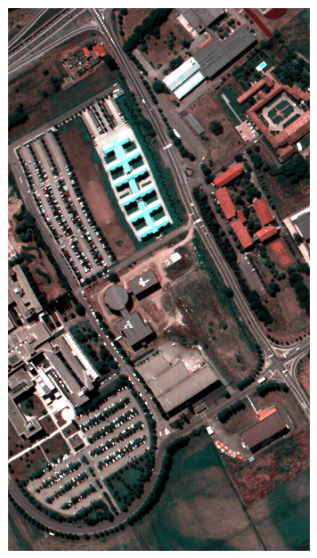

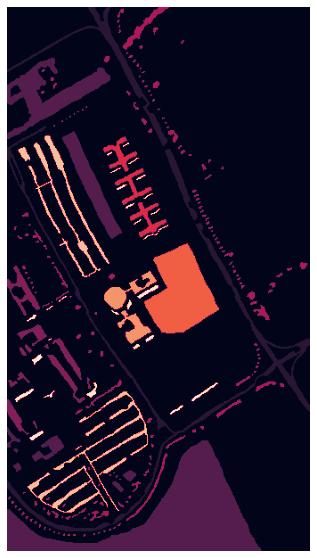

In [6]:
epp.plot_rgb(
    stacked_bands,
    rgb=(60, 30, 27),
    stretch=True,
    figsize=(10, 10),
)

plt.figure(figsize=(10, 10))
plt.imshow(gt)
plt.axis('off')
plt.show()

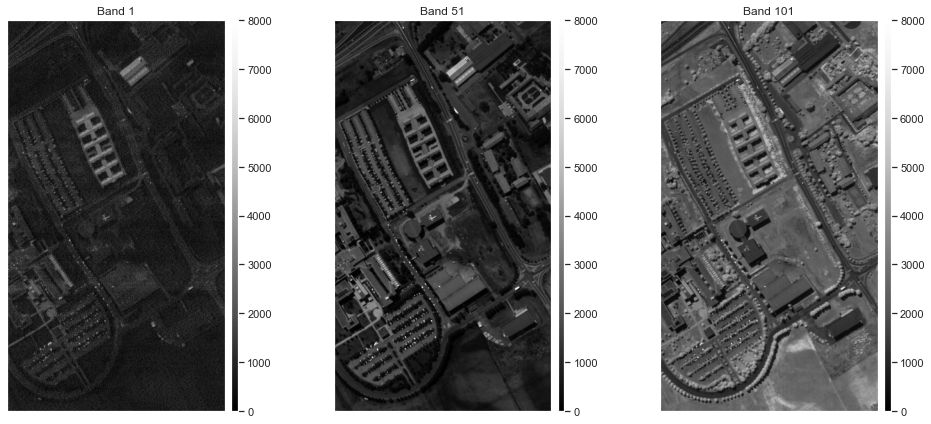

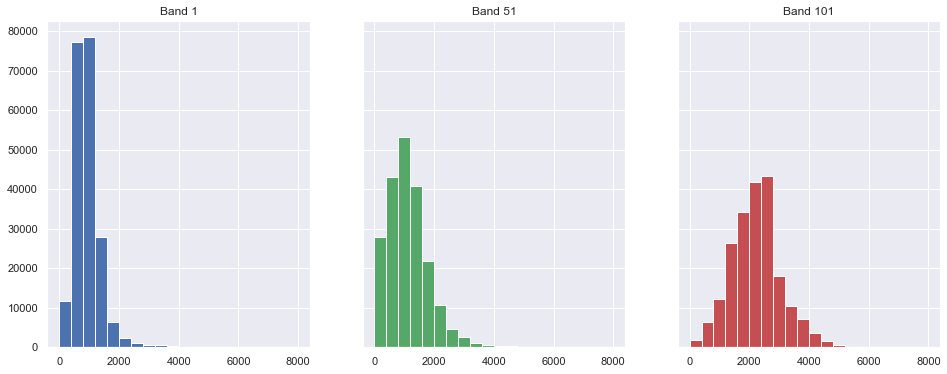

In [7]:
epp.plot_bands(sampled_bands, title=bands, figsize= (14, 6))
epp.hist(sampled_bands, colors = colors, 
         title=bands, cols=3, figsize = (16, 6))
plt.show()

In [8]:
x = df.drop(['class'], axis=1)
y = df['class']

le = preprocessing.LabelEncoder()
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.7, stratify = y)
y_encoder = le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [9]:
clf = DecisionTreeClassifier(random_state=0)
model = clf.fit(x_train.values, y_train)
print("Accuracy Score: ", round(accuracy_score(model.predict(x_test.values), y_test), 3)*100, "%")

Accuracy Score:  88.3 %


In [10]:
l = []
for i in range(data.shape[0]*data.shape[1]):
    if i in list(df.index):
        l.append(le.inverse_transform(model.predict([df.loc[i, :][:-1]])))
    else:
        l.append(0)

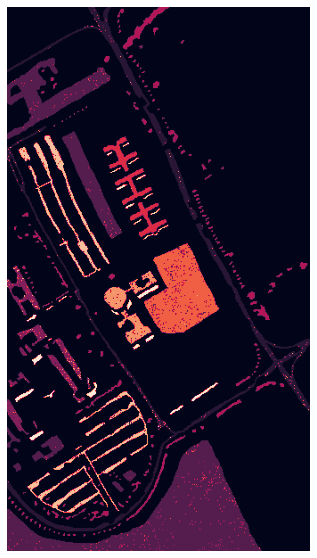

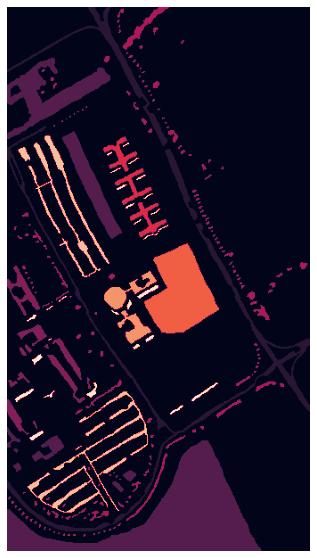

In [11]:
pred = np.array(l, dtype=object).reshape(gt.shape).astype('float')

plt.figure(figsize=(10, 10))
plt.imshow(pred)
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(gt)
plt.axis('off')
plt.show()

## Artificial Neural Network Prediction

In [12]:
class BaselineModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(BaselineModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.BatchNorm1d(hidden_size2)
        self.fc4 = nn.Linear(hidden_size2, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = F.relu(out)
        out = self.fc4(out)
        return out

In [13]:
def train_model(model, criterion, optimizer, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    loss_plot, acc_plot = [], []
    val_loss_plot, val_acc_plot = [], []
    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels.long())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data.long())

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                loss_plot.append(epoch_loss)
                acc_plot.append(epoch_acc)
            else:
                val_loss_plot.append(epoch_loss)
                val_acc_plot.append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Best val Loss: {:4f}'.format(best_loss))

    # loading best model weights
    model.load_state_dict(best_model_wts)
    train_val_plot(loss_plot, val_loss_plot, acc_plot, val_acc_plot)
    return model

In [14]:
def train_val_plot(loss_plot, val_loss_plot, acc_plot, val_acc_plot):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    ax[0].plot(loss_plot, label="Training Loss")
    ax[0].plot(val_loss_plot, label="Test Loss")
    ax[0].legend(fontsize=18)
    ax[0].grid(True)
    ax[0].set_title("Training/Test Loss", fontsize=20);
    ax[0].set_xlabel("Epoch", fontsize=18);
    ax[0].set_ylabel("Loss", fontsize=18);
    ax[1].plot(acc_plot, label="Training accuracy")
    ax[1].plot(val_acc_plot, label="Test accuracy")
    ax[1].legend(fontsize=18)
    ax[1].grid(True)
    ax[1].set_title("Training/Test Accuracy", fontsize=20);
    ax[1].set_xlabel("Epoch", fontsize=18);
    ax[1].set_ylabel("Accuracy (%)", fontsize=18);
    plt.show()
    
def confusion_matrix(data, nb_classes):
    df_cm = pd.DataFrame(data, 
                          range(nb_classes), range(nb_classes))
    plt.figure(figsize=(10,7))
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap='Blues', 
                fmt='g')
    plt.title("Confusion Matrix", fontsize = 20)
    plt.xlabel("Predicted Output", fontsize = 18)
    plt.ylabel("Expected Output", fontsize = 18)
    plt.show()
    
def acc_per_class(model, testloader, nb_classes):
    model.eval()
    confusion_mat = torch.zeros(nb_classes, nb_classes)
    class_correct = torch.zeros(10)
    class_total = torch.zeros(10)
    total = 0
    for inputs, labels in testloader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), preds.view(-1)):
            confusion_mat[t.long(), p.long()] += 1

    confusion_matrix(confusion_mat.data.cpu().numpy(), nb_classes)

    per_class_acc = 100*confusion_mat.diag()/confusion_mat.sum(1)
    for i, j in enumerate(per_class_acc.data.cpu().numpy()):
        print("Class:", i, "Accuracy:", j)
    acc = torch.mean(per_class_acc).data.cpu().numpy()
    print("Overall Accuracy: ", acc, "%")

Training complete in 0m 39s
Best val Acc: 0.929323
Best val Loss: 0.206370


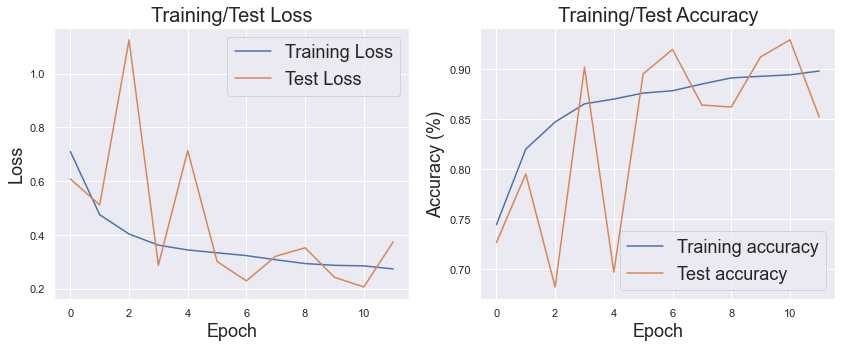

BaselineModel(
  (fc1): Linear(in_features=103, out_features=70, bias=True)
  (fc2): Linear(in_features=70, out_features=30, bias=True)
  (fc3): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=30, out_features=9, bias=True)
)

In [15]:
train = data_utils.TensorDataset(torch.tensor(x_train.values.astype(np.float32)), torch.tensor(y_train.astype(np.float32)))
trainloader = data_utils.DataLoader(train, batch_size=10, shuffle=True)
test = data_utils.TensorDataset(torch.tensor(x_test.values.astype(np.float32)), torch.tensor(y_test.astype(np.float32)))
testloader = data_utils.DataLoader(test, batch_size=10, shuffle=True)

dataloaders = {'train': trainloader, 'val': testloader}
dataset_sizes = {'train': len(trainloader.dataset), 'val': len(testloader.dataset)}
model = BaselineModel(103, 70, 30, 9)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model.parameters())
train_model(model, criterion, optimizer_ft, num_epochs=12)

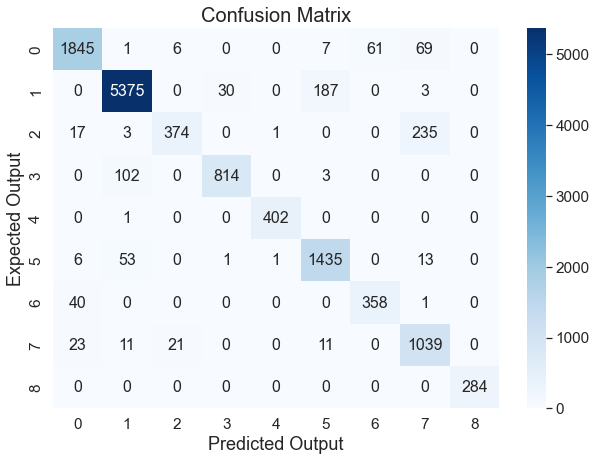

Class: 0 Accuracy: 92.76018
Class: 1 Accuracy: 96.06792
Class: 2 Accuracy: 59.365078
Class: 3 Accuracy: 88.57454
Class: 4 Accuracy: 99.75186
Class: 5 Accuracy: 95.09609
Class: 6 Accuracy: 89.72431
Class: 7 Accuracy: 94.02715
Class: 8 Accuracy: 100.0
Overall Accuracy:  90.596344 %


In [16]:
acc_per_class(model, testloader, 9)

In [17]:
l = []
model.eval()
for i in range(data.shape[0]*data.shape[1]):
    if i in list(df.index):
        l.append(le.inverse_transform(model(torch.tensor(df.loc[i, :][:-1].astype(float)).reshape(1, -1).float()).argmax(dim=1).detach().numpy()))
    else:
        l.append(0)

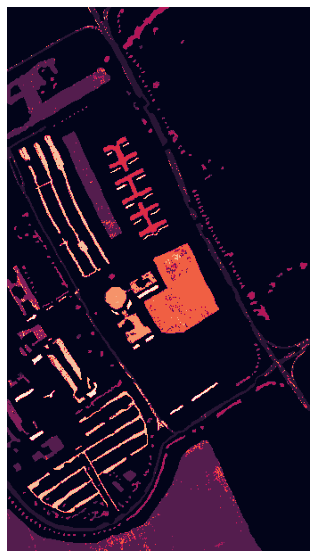

In [18]:
pred = np.array(l, dtype=object).reshape(gt.shape).astype('float')

plt.figure(figsize=(10, 10))
plt.imshow(pred)
plt.axis('off')
plt.show()

## Convolutional Neural Network Prediction

In [19]:
def zeros_pad(x, margin):
    padded_x = torch.zeros((x.shape[0] + 2 * margin, x.shape[1] + 2 * margin, x.shape[2]))
    padded_x[margin:x.shape[0] + margin, margin:x.shape[1] + margin, :] = x
    return padded_x

def create_image(x, y, window_size):
    margin = (window_size - 1) // 2
    padded_x = zeros_pad(x, margin=margin)
    patched_x = torch.zeros((x.shape[0] * x.shape[1], window_size, window_size, x.shape[2]))
    patched_y = torch.zeros((x.shape[0] * x.shape[1]))
    patch_index = 0
    for i in range(margin, padded_x.shape[0] - margin):
        for j in range(margin, padded_x.shape[1] - margin):
            patch = padded_x[i - margin:i + margin + 1, j - margin:j + margin + 1]   
            patched_x[patch_index, :, :, :] = patch
            patched_y[patch_index] = y[i-margin, j-margin]
            patch_index += 1
    patched_x = patched_x[patched_y>0,:,:,:]
    patched_y = patched_y[patched_y>0]
    patched_y -= 1
    return patched_x, patched_y

In [20]:
dimensions = 17
window_size = 25
pca = PCA(n_components=dimensions)
test_perc = 0.3

x = np.reshape(data, (-1, data.shape[2]))
x_pca = pca.fit_transform(x)
x_pca = np.reshape(x_pca, (data.shape[0], data.shape[1], dimensions))
cnn_x, cnn_y = create_image(torch.tensor(x_pca.astype(np.float32)), gt, window_size=window_size)
# number of items in batch, number of channels, number of images in sequence, height of image, width of image
cnn_x = torch.permute(cnn_x[:, None, :, :, :], (0, 1, 4, 2, 3))
cnn_x_train, cnn_x_test, cnn_y_train, cnn_y_test = train_test_split(cnn_x, cnn_y, test_size=test_perc, stratify=cnn_y)

train = data_utils.TensorDataset(cnn_x_train, cnn_y_train)
trainloader = data_utils.DataLoader(train, batch_size=10, shuffle=True)
test = data_utils.TensorDataset(cnn_x_test, cnn_y_test)
testloader = data_utils.DataLoader(test, batch_size=10, shuffle=True)

In [21]:
class CNNModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(CNNModel, self).__init__()
        self.cv1 = nn.Conv3d(1, 8, kernel_size=(3,3, 5))
        self.cv2 = nn.Conv2d(8, 16, kernel_size=(3,3))
        self.fc1 = nn.Linear(100048, 128)
        self.dp = nn.Dropout(p=0.4)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        out = self.cv1(x)
        out = F.relu(out)
        out = torch.reshape(out, (out.shape[0], out.shape[1], out.shape[2], out.shape[3]*out.shape[4])) 
        out = self.cv2(out)
        out = F.relu(out)
        out = torch.flatten(out, 1)
        out = self.fc1(out)
        out = self.dp(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

Training complete in 6m 24s
Best val Acc: 0.962207
Best val Loss: 0.285462


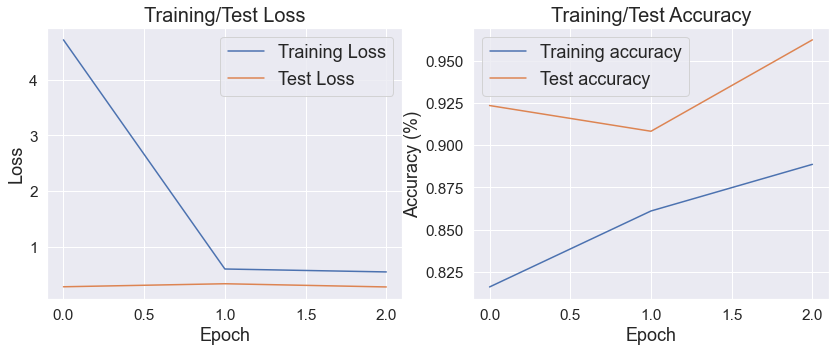

CNNModel(
  (cv1): Conv3d(1, 8, kernel_size=(3, 3, 5), stride=(1, 1, 1))
  (cv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=100048, out_features=128, bias=True)
  (dp): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
)

In [22]:
dataloaders = {'train': trainloader, 'val': testloader}
dataset_sizes = {'train': len(trainloader.dataset), 'val': len(testloader.dataset)}
model = CNNModel(103, 70, 30, 9)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model.parameters())
train_model(model, criterion, optimizer_ft, num_epochs=3)

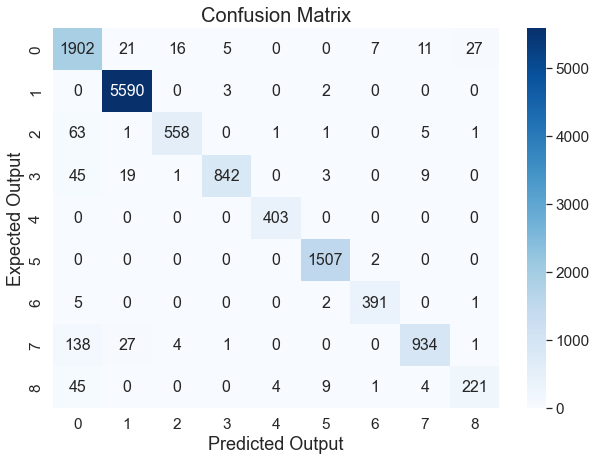

Class: 0 Accuracy: 95.625946
Class: 1 Accuracy: 99.91064
Class: 2 Accuracy: 88.57143
Class: 3 Accuracy: 91.62133
Class: 4 Accuracy: 100.0
Class: 5 Accuracy: 99.86746
Class: 6 Accuracy: 97.99499
Class: 7 Accuracy: 84.52489
Class: 8 Accuracy: 77.8169
Overall Accuracy:  92.88151 %


In [23]:
acc_per_class(model, testloader, 9)

In [24]:
x = np.reshape(data, (-1, data.shape[2]))
x_pca = pca.fit_transform(x)
x_pca = np.reshape(x_pca, (data.shape[0], data.shape[1], dimensions))
padded_x = zeros_pad(torch.tensor(x_pca), window_size//2)

pred = np.zeros((gt.shape[0], gt.shape[1]))
for h in range(gt.shape[0]):
    for w in range(gt.shape[1]):
        if int(gt[h, w]) == 0:
            continue
        else:
            model.eval()
            image_patch = padded_x[h:h+window_size, w:w+window_size, :]
            image = torch.permute(image_patch[None, None, :, :, :], (0, 1, 4, 2, 3))                             
            pred[h][w] = model(image).argmax(dim=1) + 1

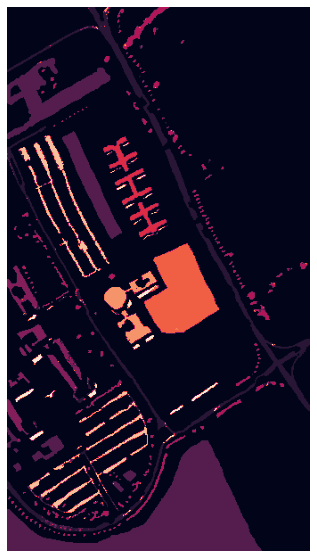

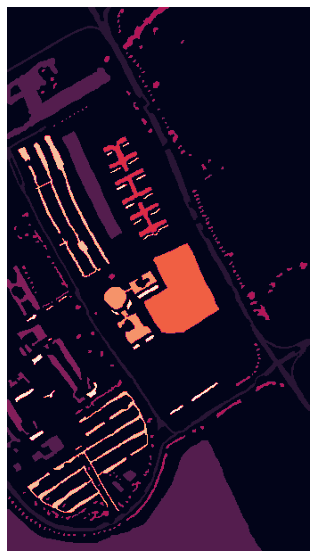

In [25]:
plt.figure(figsize=(10, 10))
plt.imshow(pred)
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(gt)
plt.axis('off')
plt.show()